# Data Handling

In this notebook we write all of the data handling relevant functions: <br>
#### read_sumo_net(filename)
    1. input: The path to the SUMO file with the city graph
    2. output: The city's graph in a networkx graph object
#### add_edge_features_from_xml(G, xml_filename, interval_begin)
    1. inputs: The networkx graph object of the city; The path xml file with the traffic data; The beginning of the interval we want to work with
    2. output: The same networkx graph object updated with the sumo graph features (traffic volumes, etc)
#### nx_to_pyg(graph)
    1. input: The networkx graph object
    2. output: The same graph converted into a pytorch graph object
#### data_preparation(data, edges_to_hide, constant_normalization)
    1. input: data: The list of pytorch graph objects with the right edge and node features; The list of edges we want to cover, a boolean, which determines wether we work with the maximum edge feature or a constant normalization.
    2. output: The prepared training data, which have -1 as edge features for unknown edges, and normalized edge features for the known. The prepared test data, which have all the edge features normalized. The sum of the squares of all the normalized edge features for benchmarking the model's performance.


In [1]:
#Necessary imports
import sumolib
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random

import torch
import torch_geometric
import torch_geometric.data as Data
import torch_geometric.utils as pyg_utils

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import json
import sys

In [2]:
#Function to read in the network we work with into a networkx object with the nodes and edges, no features yet
def read_sumo_net1(filename):
    net = sumolib.net.readNet(filename)
    G = nx.Graph()
    # Add nodes
    for node in net.getNodes():
        G.add_node(node.getID(), pos=(node.getCoord()))
    # Add edges
    for edge in net.getEdges():
        for lane in edge.getLanes():
            edge_id = lane.getEdge().getID()
            starting_node_id = net.getEdge(edge_id).getFromNode().getID()
            ending_node_id = net.getEdge(edge_id).getToNode().getID()
            G.add_edge(starting_node_id, ending_node_id, edge_id = edge_id)
    return G

In [3]:
def read_sumo_net2(filename):
    net = sumolib.net.readNet(filename)
    G = nx.Graph()
    # Add nodes
    for node in net.getNodes():
        G.add_node(node.getID(), pos=(node.getCoord()), traffic_volume_wright = 0)
    # Add edges
    for edge in net.getEdges():
        for lane in edge.getLanes():
            speed = lane.getSpeed()
            length = lane.getLength()
            average_travelling_time = length/speed
            edge_id = lane.getEdge().getID()
            starting_node_id = net.getEdge(edge_id).getFromNode().getID()
            ending_node_id = net.getEdge(edge_id).getToNode().getID()
            G.add_edge(starting_node_id, ending_node_id, edge_id = edge_id, average_traveling_time = average_travelling_time, center_leader = False, center_number = -1, in_district = False, traffic_volume = 0)
    return G

In [4]:
def get_start_end_points(G):
    #list edges and the its ids 
    #list of tuples (start_node, end_node, edge_id)
    edge_ids = list(G.edges(data='edge_id', default=1))

    #filter the list for edges which ids contain "_in" or "_out"
    new_list = [sublist[2] for sublist in edge_ids]
    start_edges = [k for k in new_list if '_in' in k]
    random_edes = [k for k in new_list if '48_E_i_0' in k]
    end_edges = [k for k in new_list if '_out' in k]
    edge_ids = start_edges + end_edges + random_edes

    edge_id_map = {data['edge_id']: (u, v) for u, v, data in G1.edges(data=True)}
    edges = []
    for edge_id in edge_ids:
        if edge_id in edge_id_map:
            u, v = edge_id_map[edge_id]
            edges.append((u, v))


    return(edges)


In [45]:
def get_k_neighbour_edges_of_edge(graph, edge, k):
    #The 2 nodes of the original edge
    u, v = edge

    #Get the neighbors of the original 2 nodes u, v
    neighbors_u = nx.single_source_shortest_path_length(graph, u, cutoff=k)
    neighbors_v = nx.single_source_shortest_path_length(graph, v, cutoff=k)

    #Combine the 2 sets and add u and v
    reachable_nodes = set(neighbors_u.keys()).union(set(neighbors_v.keys()))
    reachable_nodes.add(u)
    reachable_nodes.add(v)

    # Find all edges where both nodes are in the reachable_nodes set
    reachable_edges = []
    for node in reachable_nodes:
        for neighbor in graph.neighbors(node):
            if neighbor in reachable_nodes:
                reachable_edges.append((node, neighbor)) #.add(tuple(sorted((node, neighbor))))
    return reachable_edges

In [92]:
def create_districts(graph, edges_to_select, k: int, j: int, lower_bound: float):
    list_of_edges = list(graph.edges)
    i = 0
    while len(list_of_edges) != 0:
        if edges_to_select != []:
            edge = edges_to_select[0]
            edges_to_select.remove(edge)
            from_list = True
        else:
            edge = random.choice(list_of_edges)
            from_list = False
        if from_list:
            list_of_edge_neighbors = get_k_neighbour_edges_of_edge(graph, edge, j)
        else:
            list_of_edge_neighbors = get_k_neighbour_edges_of_edge(graph, edge, k)

        u, v = edge
        list_of_edge_neighbors.append(edge)
        intersection = [item for item in list_of_edge_neighbors if item in list_of_edges]  #set_of_edge_neighbors.intersection(set_of_edges)
        if float(len(intersection)/len(list_of_edge_neighbors)) >= lower_bound: 
            graph[u][v]['center_leader'] = True
            graph[u][v]['center_number'] = i
            graph[u][v]['in_district'] = True   
            for neighbor_edge in list_of_edge_neighbors:
                if neighbor_edge in list_of_edges:
                    u, v = neighbor_edge
                    graph[u][v]['center_number'] = i
                    graph[u][v]['in_district'] = True
            list_of_edges = [item for item in list_of_edges if item not in list_of_edge_neighbors]  #set_of_edges - set_of_edge_neighbors

        else:
            little_step_list_of_edge_neighbors = get_k_neighbour_edges_of_edge(graph, edge, 1)
            attributes = []
            for helper_edge in little_step_list_of_edge_neighbors:
                x, y = helper_edge
                attributes.append(graph[x][y]['center_number'])
            if len(attributes) == 0:
                little_step_list_of_edge_neighbors = get_k_neighbour_edges_of_edge(graph, edge, 2)
                for helper_edge in little_step_list_of_edge_neighbors:
                    x, y = helper_edge
                    attributes.append(graph[x][y]['center_number'])
            graph[u][v]['center_number'] = random.choice(attributes)
            graph[u][v]['in_district'] = True
            list_of_edges = [item for item in list_of_edges if item != edge]
        i += 1

In [93]:
def plot_graph_data_debug(G):
    # Retrieve the position of the nodes from the 'pos' attribute
    pos = nx.get_node_attributes(G, 'pos')

    # Separate the edges based on the 'in_district' attribute
    edges_in_district = [(u, v) for u, v, d in G.edges(data=True) if d['center_leader']]
    edges_out_district = [(u, v) for u, v, d in G.edges(data=True) if not d['center_leader']]

    # Draw the entire graph but without edges (so we can control edge colors separately)
    nx.draw(G, pos, with_labels=False, node_size=1, edge_color='none') 

    # Draw edges with custom colors
    nx.draw_networkx_edges(G, pos, edgelist=edges_in_district, edge_color='black', width=4)
    nx.draw_networkx_edges(G, pos, edgelist=edges_out_district, edge_color='green', width=1)
    # Display the plot
    plt.show()

In [94]:
class Edges:
    def __init__(self, from_node, to_node, edge_id="", weight=0, pairs_it_connects=[]):
        self.edge_id = edge_id
        self.from_node = from_node
        self.to_node = to_node
        self.weight = weight
        self.pairs_it_connects = pairs_it_connects

def get_edges_from_shortest_path(graph, node1, node2, weight):
    road = nx.dijkstra_path(graph, node1, node2, weight = weight)
    list_of_edges = []
    for i in range(len(road)-1):
        list_of_edges.append(Edges(road[i], road[i+1], graph[road[i]][road[i+1]]['edge_id'], 0, [node1, node2]))
    return list_of_edges

def update_all_edges(all_edges, road):
    edge_ids_in_all_edges = []
    for edge in all_edges:
        edge_ids_in_all_edges.append(edge.edge_id)
    edge_ids_in_roads = []
    for edge in road:
        edge_ids_in_roads.append(edge.edge_id)
    for id in edge_ids_in_roads:
        if id in edge_ids_in_all_edges:
            index_all_edges = edge_ids_in_all_edges.index(id)
            index_road = edge_ids_in_roads.index(id)
            all_edges[index_all_edges].pairs_it_connects.append(road[index_road].pairs_it_connects)
            all_edges[index_all_edges].weight += road[index_road].weight
        else:
            index_road = edge_ids_in_roads.index(id)
            all_edges.append(road[index_road])
        
            

def get_shortest_paths_edges(graph):
    district_leaders = [(u, v) for u, v, d in graph.edges(data=True) if d['center_leader']]
    nodes_from = [district_leaders[i][0] for i in range(len(district_leaders))]
    nodes_to = [district_leaders[i][1] for i in range(len(district_leaders))]
    all_edges = []
    for node1 in nodes_from:
        for node2 in nodes_to:
            road = get_edges_from_shortest_path(graph, node1, node2, 'average_traveling_time')
            update_all_edges(all_edges, road)

    return len(all_edges)

def get_weight_from_pytorch(nx_graph, data):
    node_id_to_index = {node_id: i for i, node_id in enumerate(nx_graph.nodes)}
    index_to_node_id = {i: node_id for node_id, i in node_id_to_index.items()}
    for j in range(len(data)):
        for i in range(len(node_id_to_index)):
            nx_graph[index_to_node_id[data[j].edge_index[:,i].tolist()[0]]][index_to_node_id[data[j].edge_index[:,i].tolist()[1]]]['traffic_volume'] += float(data[j].edge_attr[i])/len(data)

#def get_district_weights(nx_graph):
    

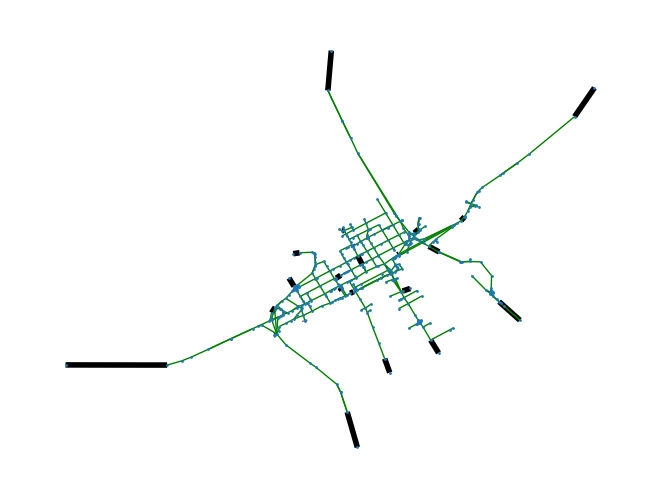

In [96]:
data = torch.load('../Data/data.pth')
G1 = read_sumo_net2('../Data/s_gyor.net.xml') # type: ignore
get_weight_from_pytorch(G1, data)
edges_to_select = get_start_end_points(G1)
G1.remove_edge('370502474', 'cluster_1184280674_4523347826_4523347827')
G1.remove_node('370502474')
G1.remove_node('cluster_1184280674_4523347826_4523347827')
create_districts(G1, edges_to_select, 3, 7, 0.3)
get_shortest_paths_edges(G1)
plot_graph_data_debug(G1)

In [74]:
def plot_graph_data_debug(G):
    # Retrieve the position of the nodes from the 'pos' attribute
    pos = nx.get_node_attributes(G, 'pos')

    # Separate the edges based on the 'in_district' attribute
    edges_in_district = [(u, v) for u, v, d in G.edges(data=True) if d['in_district']]
    edges_in_district = [('1225263431', '3192392594')]
    
    get_k_neighbour_edges_of_edge(G, edges_in_district, 4)
    edges_out_district = [(u, v) for u, v, d in G.edges(data=True) if not d['in_district']]

    # Draw the entire graph but without edges (so we can control edge colors separately)
    nx.draw(G, pos, with_labels=False, node_size=1, edge_color='none') 

    # Draw edges with custom colors
    nx.draw_networkx_edges(G, pos, edgelist=edges_in_district, edge_color='black', width=1)
    nx.draw_networkx_edges(G, pos, edgelist=edges_out_district, edge_color='green', width=4)
    # Display the plot
    plt.show()

In [86]:
def plot_graph_data_debug2(G):
    # Retrieve the position of the nodes from the 'pos' attribute
    pos = nx.get_node_attributes(G, 'pos')

    # Separate the edges based on the 'in_district' attribute
    edges_in_district = [('1225263431', '3192392594'), ('1638776765', '593274978'), ('1225263169', 'cluster_cluster_289028592_gneJ32_gneJ89_gneJ92'), ('289028665', '4923673800'), ('cluster_cluster_289028592_gneJ32_gneJ89_gneJ92', 'cluster_gneJ91_gneJ96'), ('593274974', '593293219'), ('cluster_cluster_289028592_gneJ32_gneJ89_gneJ92', 'cluster_gneJ90_gneJ93'), ('314183164', 'cluster_1140866508_1416081317'), ('cluster_cluster_cluster_289029346_gneJ81_gneJ82_gneJ94_gneJ95', 'cluster_gneJ91_gneJ96'), ('cluster_cluster_cluster_289029346_gneJ81_gneJ82_gneJ94_gneJ95', 'cluster_gneJ90_gneJ93'), ('314183164', '593274974'), ('cluster_2894959538_gneJ29', 'cluster_gneJ30_gneJ31'), ('1182772245', '593293219'), ('4923673781', '4923673800'), ('1140866677', '1140866679'), ('1416081318', '314183164'), ('314183164', 'cluster_cluster_cluster_cluster_3192392565_cluster_gneJ106_gneJ123_cluster_cluster_cluster_2907026059_gneJ118_gneJ114_gneJ122_gneJ115_gneJ130'), ('1182772245', '593274978'), ('289028665', '3192392594'), ('1225263169', 'cluster_1140866508_1416081317'), ('432621768', '4923673781'), ('289028061', '3192392614'), ('1140866550', '1638776753'), ('1140866679', '1225263431'), ('1416081318', '593274978'), ('1140866679', 'cluster_1140866508_1416081317'), ('1140866444', '3192392614'), ('1508952856', '1871871046'), ('1140866550', '1140866677'), ('1140866616', 'cluster_1140866508_1416081317'), ('1638776753', '289028061'), ('289028665', 'cluster_cluster_289028592_gneJ32_gneJ89_gneJ92'), ('cluster_cluster_289028592_gneJ32_gneJ89_gneJ92', 'cluster_gneJ30_gneJ31'), ('1140866679', '593274978'), ('1638776765', '1871871046'), ('1140866550', '1182772207'), ('1140866550', '1508952856'), ('1140866444', '289028665'), ('1225263431', '3192392594')]    
    edges_in_district = [('gneJ536', 'gneJ698')]
    edges_out_district = [(u, v) for u, v in G.edges if (u,v) not in edges_in_district]
    edges_out_district = [('gneJ696', 'gneJ536')]
    # Draw the entire graph but without edges (so we can control edge colors separately)
    nx.draw(G, pos, with_labels=False, node_size=1, edge_color='none') 

    # Draw edges with custom colors
    nx.draw_networkx_edges(G, pos, edgelist=edges_in_district, edge_color='black', width=2)
    nx.draw_networkx_edges(G, pos, edgelist=edges_out_district, edge_color='green', width=1)
    # Display the plot
    plt.show()

In [9]:
#Function to add the features to the network graph we created already
def add_edge_features_from_xml(G, xml_filename, interval_begin):
    # Parse the XML file
    tree = ET.parse(xml_filename)
    root = tree.getroot()
    #Find the interval corresponding to the interval_begin time 
    interval = root.find(f'.//interval[@begin="{interval_begin}"]')
    #Extract all the features of the edges
    edges = interval.findall('.//edge')
    for edge in edges:
        edge_id = edge.get('id')
        edge_features = {}
        edge_features['left'] = edge.get('left')
        #We can add other features here
        #Iterate through the edges in the existing NetworkX graph
        for xml_edge_id, xml_edge_data in G.edges.items():
            if G.get_edge_data(xml_edge_id[0],xml_edge_id[1])['edge_id'] == edge_id:
                G.edges[xml_edge_id].update(edge_features)
    return G

In [10]:
#Function to convert the networkx graph into a pytorch graph object
def nx_to_pyg(graph):
    # Convert NetworkX graph to PyTorch Geometric Data object
    pyg_data = Data.Data()
    #We have to number the nodes, because that is how Data object works
    # Mapping between string node IDs and numerical indices
    node_id_to_index = {node_id: i for i, node_id in enumerate(graph.nodes)}

    # Set node features
    num_nodes = graph.number_of_nodes()
    node_features = np.zeros((num_nodes, 2))  # Assuming num_features is known, this is important to change, if we want to change something, altough I do not think that will be the case for us
    for i, (node, features) in enumerate(graph.nodes(data=True)):
        node_features[i] = [features['pos'][0], features['pos'][1]]  # Add node features accordingly, this case the coordinates
    pyg_data.x = torch.tensor(node_features, dtype=torch.float)

    # Set edge features and edge indices
    edge_index = []
    edge_features = []
    for u, v, features in graph.edges(data=True):
        # Map string node IDs to numerical indices
        u_index = node_id_to_index[u]
        v_index = node_id_to_index[v]
        edge_index.append([u_index, v_index])
        edge_features.append([float(features['left'])])  # Add edge features accordingly, if we add more features, we have to change this line

    pyg_data.edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    pyg_data.edge_attr = torch.tensor(edge_features, dtype=torch.float)

    return pyg_data

In [11]:
#Function to prepare the data (list of pytorch graph objects with the correct node and edge features)
def data_preparation(data, edges_to_hide, constant_normalization):
    prepared_training_data = []
    prepared_test_data = []
    summa = 0
    for graph in data:
        edge_features = graph.edge_attr
        if constant_normalization==False:
            max_value = edge_features.max()
        else:
            max_value = (2*1800)/4 #In Győr for the majority of the city there's only 2 lanes on the busiest road
        normalized_edge_features = edge_features / max_value
        graph.edge_attr = normalized_edge_features
        graph_test = graph.clone()
        edge_features_to_sum = graph_test.edge_attr
        squared_edge_features = edge_features_to_sum**2
        summa += squared_edge_features.mean()
        graph.edge_attr[edges_to_hide] = -1
        prepared_training_data.append(graph)
        prepared_test_data.append(graph_test)
    return prepared_training_data, prepared_test_data, summa/len(data)

{('2898894872', '1182626900'): -1,
 ('2898894872', '391289186'): -1,
 ('1182626900', '2917038141'): -1,
 ('1182626900', '1182626924'): -1,
 ('cluster_365935391_gneJ681', '3192392567'): -1,
 ('cluster_365935391_gneJ681', '3192392599'): -1,
 ('cluster_365935391_gneJ681', 'cluster_gneJ679_gneJ680'): -1,
 ('3192392567', 'cluster_gneJ679_gneJ680'): -1,
 ('3192392567', 'cluster_365935389_4924343194'): -1,
 ('cluster_2722529171_gneJ401', '865267201'): -1,
 ('cluster_2722529171_gneJ401', '1416081293'): -1,
 ('cluster_2722529171_gneJ401', '865267189'): -1,
 ('865267201', '1982987916'): -1,
 ('865267201', '4706812286'): -1,
 ('1416081293', '865267163'): -1,
 ('865267163', '1186526720'): -1,
 ('865267163', '865267151'): -1,
 ('310013392', 'cluster_1182772225_3192392684'): -1,
 ('310013392', '1508952878'): -1,
 ('310013392', '1871871069'): -1,
 ('cluster_1182772225_3192392684', '593274980'): -1,
 ('4386097268', 'cluster_1186526849_gneJ146'): -1,
 ('4386097268', 'cluster_cluster_312711598_gneJ154_g

1358
